In [26]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test



In [27]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
i_doe = 1
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.985561943483206, NMSE: 0.014438056516794005
gpr_fn2_ex22 performace: R² Score: 0.948431197392554, NMSE: 0.05156880260744601
[5.02530788e-16 6.41526561e-17 3.67990489e-17 3.78867775e-17
 1.06090691e-15 8.56773731e-16 2.50726825e-15 1.32192214e-14]
[1.27977665e-15 1.39384501e-16 8.58310826e-17 8.54746060e-17
 1.71600769e-15 1.52086330e-15 4.17359007e-15 2.31717568e-14]


### Plot th histogram of energy

In [ ]:
# Create subplots for the 8 histograms
#fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns
#axes = axes.flatten()  # Flatten to easily iterate
## Plot each histogram
#for i in range(8):
#    axes[i].hist(np.log(energy_frf_ex22[:, i]), bins=30, alpha=0.7, color='blue', edgecolor='black')
#    axes[i].set_title(f"Histogram of FRF {i+1}")
#    axes[i].set_xlabel("Value")
#    axes[i].set_ylabel("Frequency")
## Adjust layout
#plt.tight_layout()
#plt.show()

[8.38950090e-17 2.07774340e-17 1.53652408e-17 1.01941204e-17
 2.60217501e-16 4.37129159e-16 2.17211959e-15 2.16209439e-15]
[1.93070150e-16 4.28334812e-17 3.83769632e-17 2.02494022e-17
 4.07575513e-16 7.73079288e-16 4.08336670e-15 3.35373105e-15]


In [28]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
298
gpr_fn1_ex22 performace: R² Score: 0.9749199532331219, NMSE: 0.02508004676687812
gpr_fn2_ex22 performace: R² Score: 0.7485004847073207, NMSE: 0.2514995152926794
[1.30916139e-16 3.64192216e-17 2.05856369e-17 1.33173493e-17
 3.43776563e-16 9.84229029e-16 1.70809832e-15 3.60583888e-15]
[3.33689810e-16 8.27070306e-17 5.11919029e-17 2.87800405e-17
 6.01932001e-16 1.82644452e-15 3.17960114e-15 6.44292351e-15]


In [29]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex220/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
397
gpr_fn1_ex22 performace: R² Score: 0.9701397237476515, NMSE: 0.029860276252348585
gpr_fn2_ex22 performace: R² Score: 0.9101330250656501, NMSE: 0.08986697493434992
[8.38950090e-17 2.07774340e-17 1.53652408e-17 1.01941204e-17
 2.60217501e-16 4.37129159e-16 2.17211959e-15 2.16209439e-15]
[1.93070150e-16 4.28334812e-17 3.83769632e-17 2.02494022e-17
 4.07575513e-16 7.73079288e-16 4.08336670e-15 3.35373105e-15]


### Optimization by GA

In [56]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    x = np.array(x)
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2,)


bounds = [(0, 1) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0.3,0.7)
bounds[18] = (0,0.7)

# Custom parameter generator
def generate_individual():
    return [np.random.uniform(low, high) for low, high in bounds]

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define individual and population
toolbox = base.Toolbox()
#toolbox.register("attr_float", lambda: [generate_param(low, high) for low, high in bounds])  # Parameter bounds: [0, 1]
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=19)  # 20 parameters
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=2000)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 300
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:10]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	2000  
1  	1483  
2  	1500  
3  	1565  
4  	1526  
5  	1537  
6  	1500  
7  	1487  
8  	1522  
9  	1536  
10 	1506  
11 	1482  
12 	1491  
13 	1504  
14 	1552  
15 	1535  
16 	1509  
17 	1484  
18 	1535  
19 	1526  
20 	1558  
21 	1527  
22 	1536  
23 	1469  
24 	1522  
25 	1529  
26 	1547  
27 	1517  
28 	1528  
29 	1524  
30 	1478  
31 	1486  
32 	1521  
33 	1534  
34 	1495  
35 	1542  
36 	1471  
37 	1542  
38 	1506  
39 	1570  
40 	1522  
41 	1543  
42 	1536  
43 	1500  
44 	1563  
45 	1551  
46 	1510  
47 	1515  
48 	1512  
49 	1526  
50 	1573  
51 	1574  
52 	1528  
53 	1499  
54 	1560  
55 	1508  
56 	1526  
57 	1549  
58 	1518  
59 	1486  
60 	1547  
61 	1530  
62 	1479  
63 	1483  
64 	1544  
65 	1505  
66 	1469  
67 	1488  
68 	1473  
69 	1534  
70 	1566  
71 	1509  
72 	1543  
73 	1488  
74 	1510  
75 	1506  
76 	1503  
77 	1515  
78 	1513  
79 	1568  
80 	1526  
81 	1500  
82 	1555  
83 	1523  
84 	1501  
85 	1489  
86 	1552  
87 	1555  
88 	1527  
89 	1519  

[0.9633663326531775, 0.4872164377611629, 0.09900427148891033, 0.2833942686685907, 0.46386708554370804, 0.8916429822906604, 0.15139880591012522, 0.6212178746393571, 0.2561613614489595, 0.24918901142598027, 1.6288224478342945, 0.17118392360436613, 0.30382645476574943, 0.6583309873536858, 0.2617405687280677, 0.5878795647215438, 0.3333124575603544, 0.7501688779123872, 0.3920089497693813]


### OPtimization by L-BFGS-B

In [57]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0, 1) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0.3,0.7)
bounds[18] = (0,0.7)
# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
x0 = top_10_candidates[5][0]
x_top_10_candidates = np.zeros([10,19])

for i_top in range(10):
    # Perform optimization
    result = minimize(objective_function, top_10_candidates[i_top][0], bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)


Optimized Parameters: [0.8606011  0.43417782 0.54062178 0.32171552 0.84829941 0.97097429
 0.28960412 0.21337976 0.14051154 0.11102397 0.96564407 0.55212154
 0.53351392 0.95525302 0.36764457 0.7397912  0.96594992 0.64347709
 0.63070849]
Objective Function Value: 2.820571030934458e-06
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.134404120989984, fn_2: 18.86720549239044
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.1855982692623, fn_2: 19.199969856140342
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.21119993159391, fn_2: 18.867199793076566
Optimized Parameters: [0.81746453 0.37835953 0.32016126 0.33605036 0.64407362 0.95029377
 0.49607876 0.00105441 0.11646691 0.01053005 0.85653793 0.73811006
 0.70021372 0.99419275 0.67594458 0.75883721 0.9733525  0.62928131
 0.35703591]
Objective Function Value: 3.7954201168408355e-06
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.134411437557901, fn_2: 18.867200398267414
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.185584875627228, fn_2: 19.1999923086571


(9, 19)


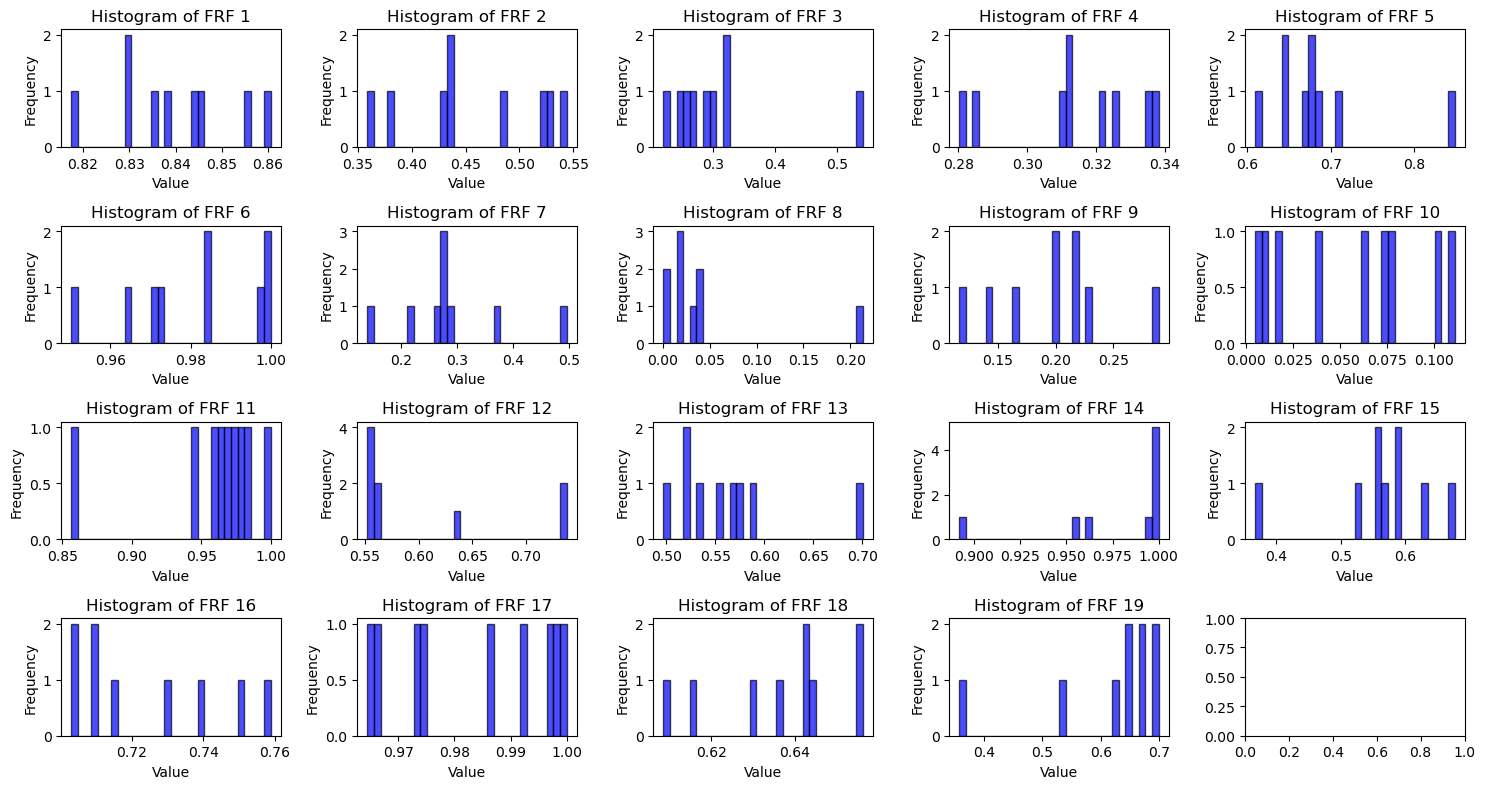

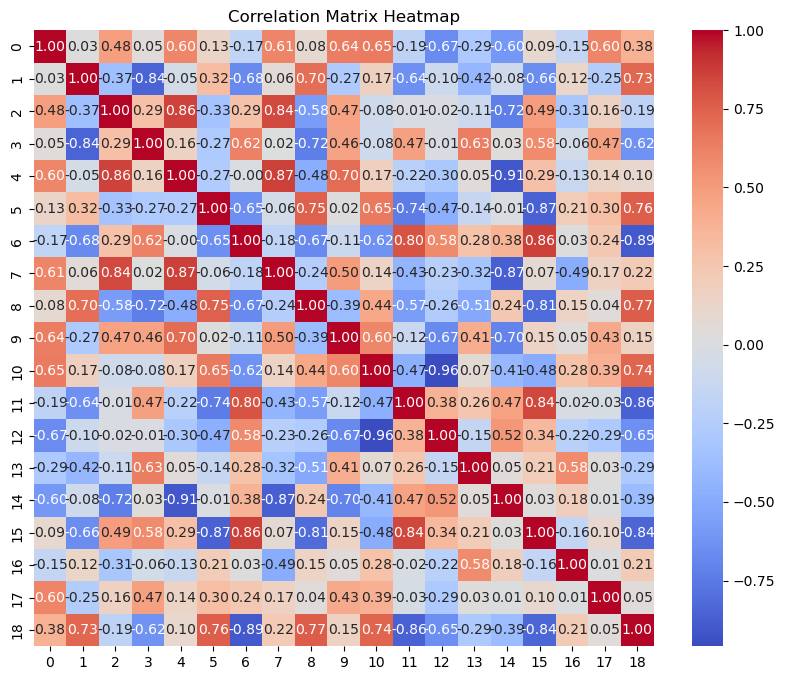

In [72]:
print(np.shape(x_top_10_candidates))
# Create subplots for the 8 histograms
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily iterate
# Plot each histogram
for i in range(19):
    axes[i].hist((x_top_10_candidates[:, i]), bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Histogram of FRF {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
# Adjust layout
plt.tight_layout()
plt.show()

# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Compute the ratio of measurement energy and simulation energy

In [ ]:
freq_resample = np.linspace(0, 50, 101)
FRFs_exp_ex22 = np.zeros([8,len(freq_resample)])
FRFs_exp_ex221 = np.zeros([8,len(freq_resample)])
FRFs_exp_ex220 = np.zeros([8,len(freq_resample)])
energy_FRFs_exp_ex22 = np.zeros([8])
energy_FRFs_exp_ex221 = np.zeros([8])
energy_FRFs_exp_ex220 = np.zeros([8])

i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 4
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))

    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex22[i,:] = i_resample
    energy_FRFs_exp_ex22[i] = np.sum(i_resample**2)

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex220[i,:] = i_resample
    energy_FRFs_exp_ex220[i] = np.sum(i_resample**2)

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex221[i,:] = i_resample
    energy_FRFs_exp_ex221[i] = np.sum(i_resample**2)

print(np.mean(energy_FRFs_exp_ex22/energy_frf_ex22,axis=0) )
print(np.mean(energy_FRFs_exp_ex221/energy_frf_ex221,axis=0))
print(np.mean(energy_FRFs_exp_ex220/energy_frf_ex220,axis=0))




[93.71327555 59.65757726 32.86638689 94.60632848  6.89303438  5.89679674
 10.33030458  5.70356597]
[264.25213684  82.25340477  51.50893735 188.31620448   9.80419736
  16.99626701  15.22790992   9.6205183 ]
[444.7704914  166.04570904  76.59662327 311.33075126  30.31402123
  23.81450361  33.51508202  31.41408101]


### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [40]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 17.1025 seconds.


### Fine tuning using PSO method

In [ ]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    return FRFs_simu



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1

result = objective_function(np.array(x_best))



(24, 101)
[[ 1.00000000e-12  1.00000000e-12  1.01900380e-12 ... -1.00000000e-12
  -1.00000000e-12 -1.00000000e-12]
 [ 1.00000000e-12  1.00000000e-12  1.00000000e-12 ... -1.00000000e-12
  -1.00000000e-12 -1.00000000e-12]
 [ 0.00000000e+00  0.00000000e+00  1.90038048e-14 ... -1.00000000e-12
  -1.00000000e-12 -1.00000000e-12]
 ...
 [ 3.00000000e-12  3.00000000e-12  3.07601522e-12 ...  1.00000000e-12
   1.00000000e-12  1.00000000e-12]
 [ 5.00000000e-12  5.00000000e-12  5.11402283e-12 ...  4.00000000e-12
   3.51020408e-12  3.00000000e-12]
 [ 9.00000000e-12  9.00000000e-12  9.17103424e-12 ...  7.00000000e-12
   6.51020408e-12  6.00000000e-12]]


In [ ]:
result_norm = result/np.max(np.abs(result))
channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]

for i in range(12):
    plt.plot(freq_resample,result_norm [channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")
for i in range(12):
    plt.plot(freq_resample,result_norm [channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")

plt.show()
print(np.shape(result))
print(result)

In [ ]:
freq_resample = np.linspace(0, 50, 101)
FRFs_exp = np.zeros([24,len(freq_resample)])

i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 8
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i,:] = i_resample

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+8,:] = i_resample

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+16,:] = i_resample

FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
for i in range(12):
    plt.plot(freq_resample,FRFs_exp_norm[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")
for i in range(12):
    plt.plot(freq_resample,FRFs_exp_norm[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")

plt.show()


### Objecttive function for comparison with expirmental data

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.8056780012876708
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 7.2499 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04214071823865263
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 26.5638 seconds.
 Extract all modal information , duration 4.0561 seconds.
 /PO

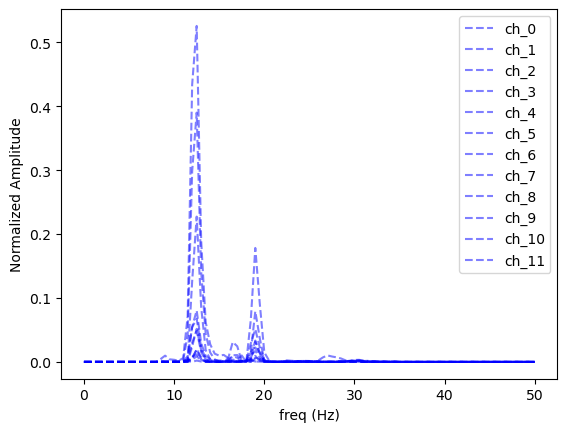

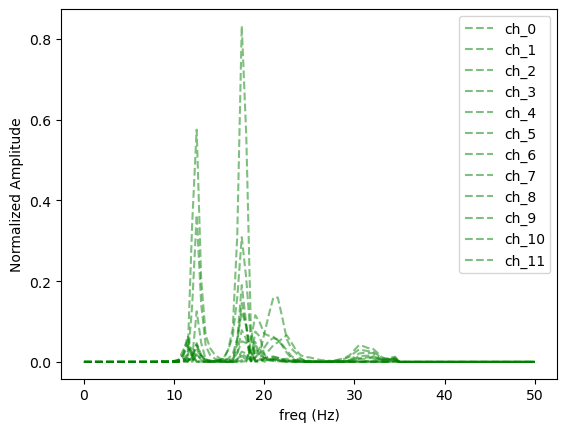

15.708117706371706
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.759886254111074
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.0371 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04841221214888561
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 27.2000 seconds.
 Extract all modal information , duration 3.

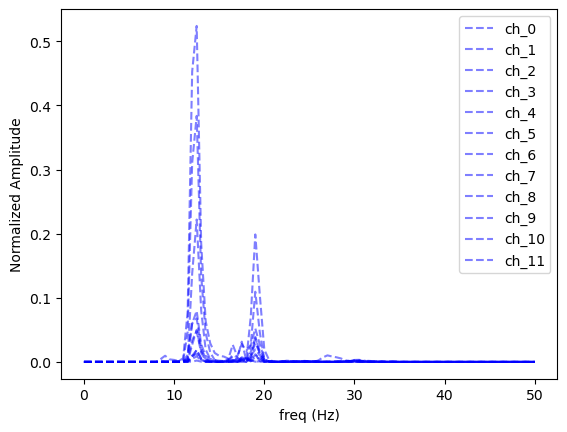

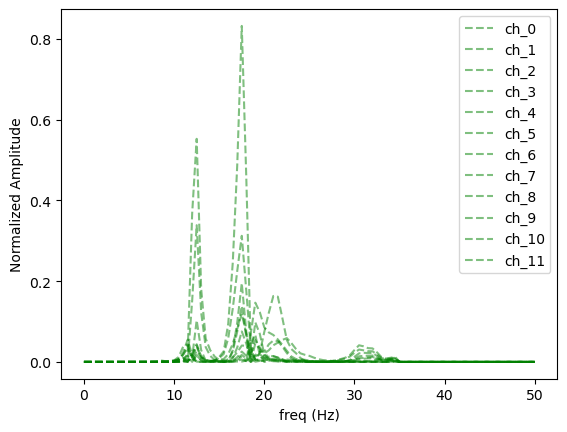

16.57925956464634
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.8271326134182906
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 5.9995 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04793016053131747
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 26.0074 seconds.
 Extract all modal information , duration 4.

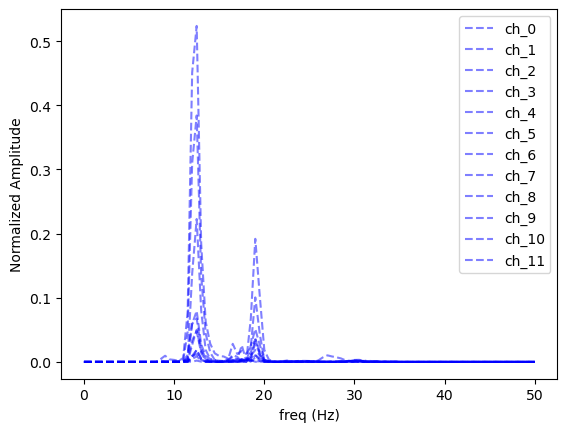

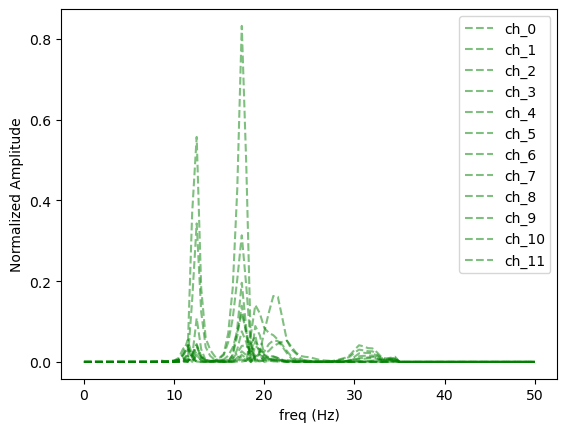

16.114618385367784
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.735636644321689
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.0647 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04803012607648046
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 26.8390 seconds.
 Extract all modal information , duration 4.

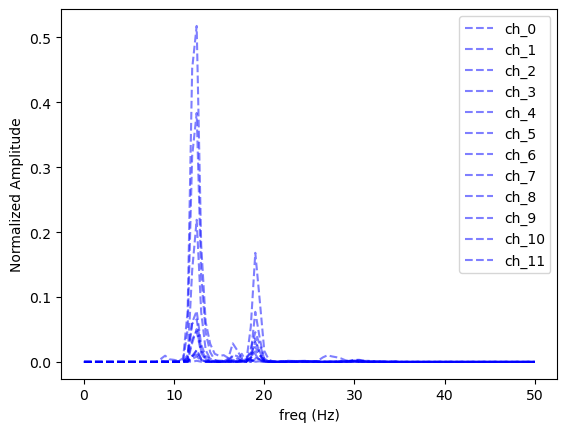

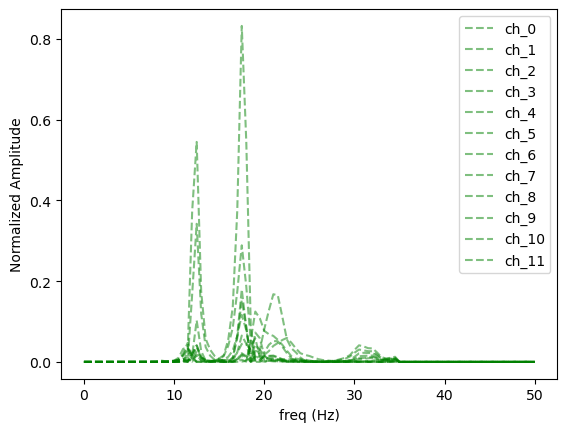

15.736137804018039
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.8559914675845497
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.2229 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04842311742995916
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 31.9702 seconds.
 Extract all modal information , duration 4

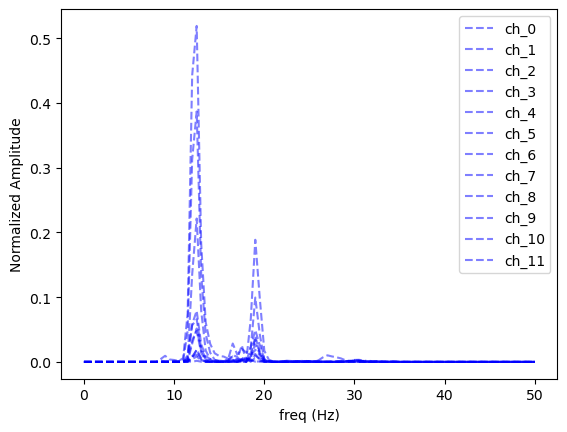

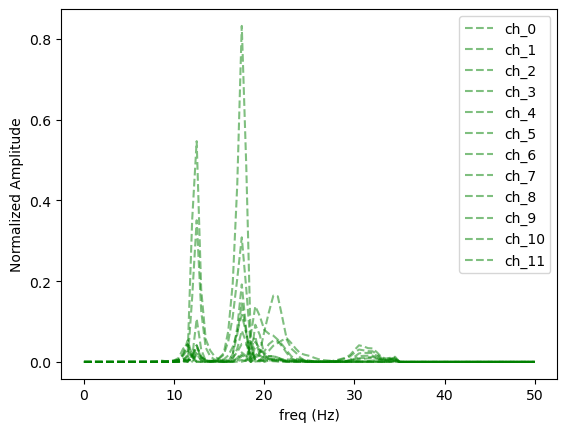

16.16029741303408
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.8526633378375634
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.0322 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04898636702623473
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 26.0173 seconds.
 Extract all modal information , duration 4.

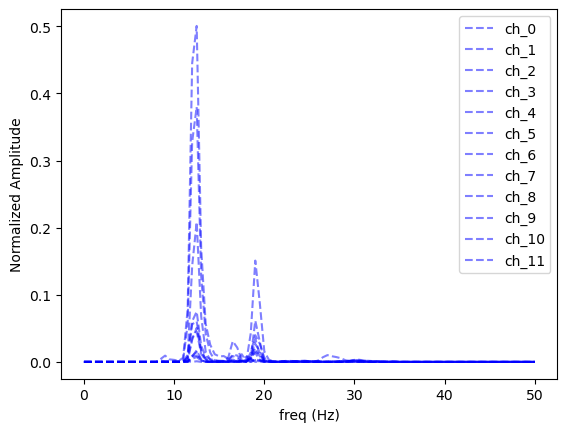

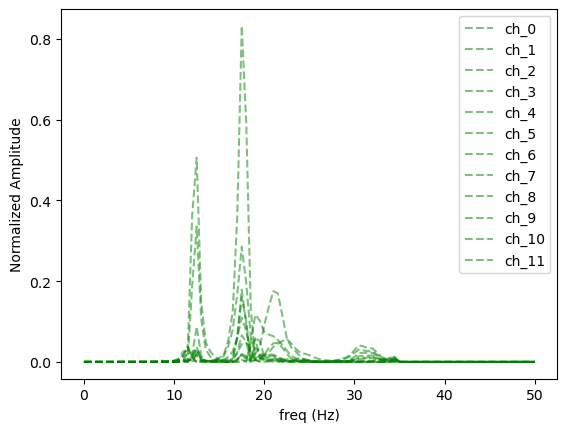

15.371238483936198
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.894378586074676
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.0240 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04884310959768073
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 25.5149 seconds.
 Extract all modal information , duration 4.

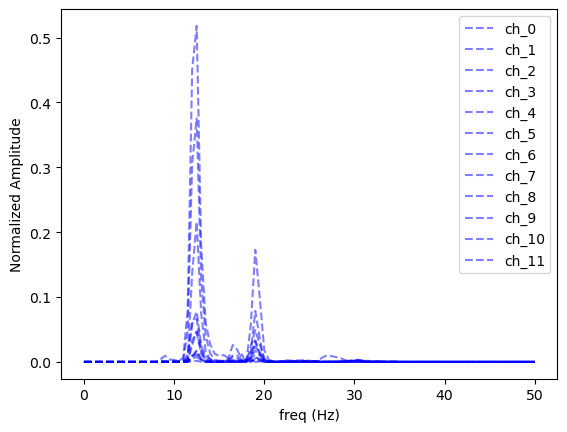

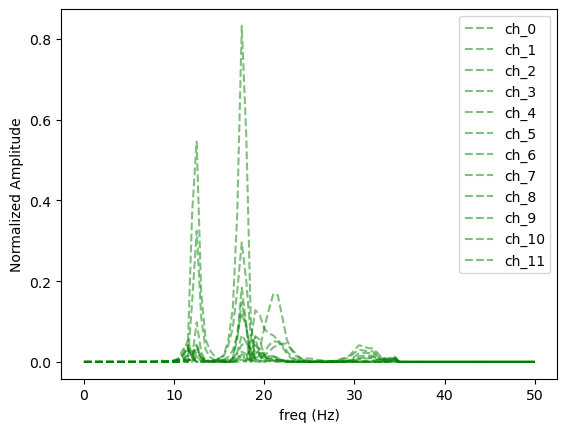

15.519839658253499
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.896667714864253
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 5.9985 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.045763421631787995
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 25.8367 seconds.
 Extract all modal information , duration 4

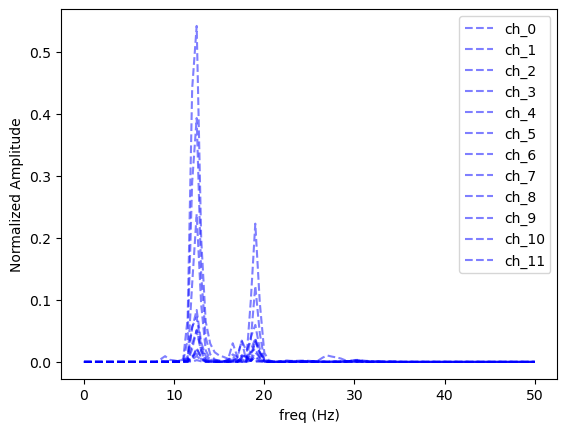

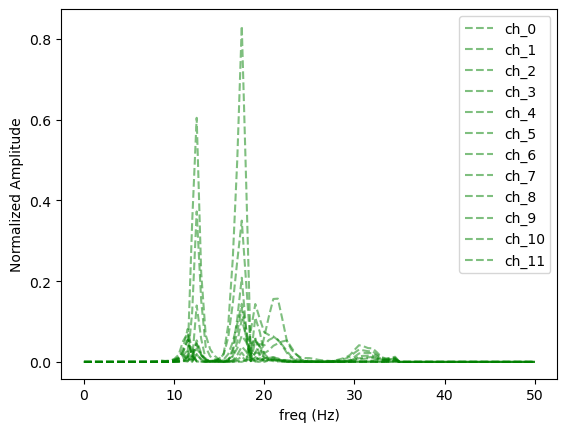

17.34868422184583
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.8535178042526774
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.8176 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04761416970708517
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 25.8851 seconds.
 Extract all modal information , duration 4.

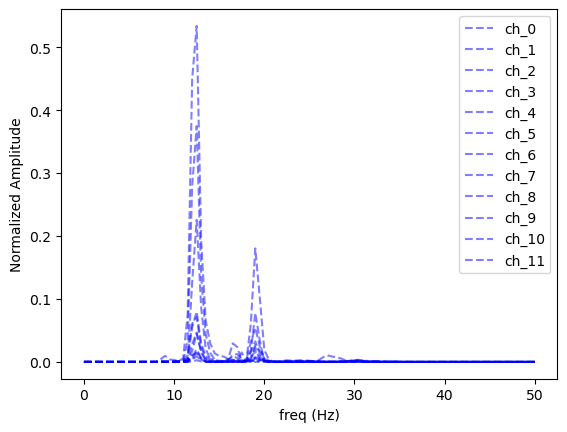

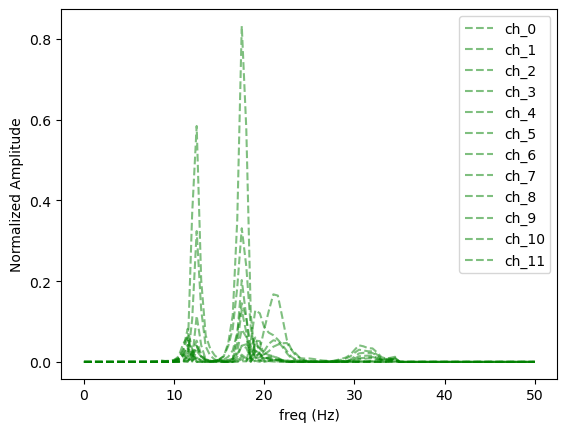

16.231834340163836


In [58]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    print(error_percentage)

    return error, error_percentage



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1

freq_resample = np.linspace(0, 50, 101)
for i_top_para in range(np.shape(x_top_10_candidates)[0]):
    result, error_per = objective_function(x_top_10_candidates[i_top_para,:])
    channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
    channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]

    for i in range(12):
        plt.plot(freq_resample,result[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized Amplitude")
    plt.show()
    for i in range(12):
        plt.plot(freq_resample,result[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized Amplitude")
    plt.show()
    print(error_per)



### Validation from L-BFGS-B

In [25]:
print(top_10_candidates[0][0])


[0.8810778583983437, 1.0421829542813008, 0.2691239402618794, 0.27401971376469, 0.35912863849708443, 0.9208976636404049, 0.2739284058412273, 0.22934103595847424, 0.26605675848363, 0.2440887746112583, 0.8614452131096842, 0.288480191560488, 0.620263668206286, 0.6512406657120968, 0.39101805999341466, 0.538905092752883, 0.47224840460973483, 0.735187269185666, 0.45356930015620656]


In [59]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_top_10_candidates[5,:]
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




[0.6288402758241182, 0.8174522272175899, 0.03722026146832442, 0.15713293942388545, 0.22189642079086003, 0.6288402758241182]
[29965226283.216927, 14247449148.528913, 10847740418.211416, 15787028995.754766, 10100538575.221807, 29965226283.216927]
[3354.779954245916, 2423.5111829374237, 2502.573076272842, 3201.2048341791856, 2594.9574882405914, 3354.779954245916]
[421.1300527823065, 2050.311122749486, 0.33]
3.8526633378375634
0.04898636702623473


### Visualization

### Excitation 221, compare to exp 9

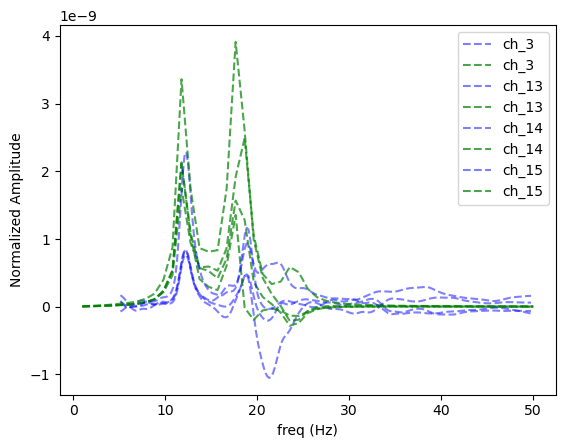

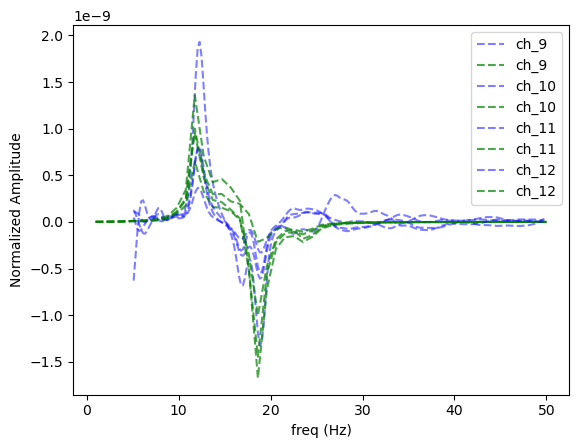

[12.0386362 12.0386362 12.0386362 12.0386362 12.0386362 12.0386362
 12.0386362 12.0386362]
12.0386362 18.249544157142854 0.7469840901037517 0.5662274945283808


In [60]:
i_file = 9
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []


for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex221
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
i_ch_disp = [9,10,11,12,3,13,14,15]

mode_freq_1_list = np.zeros(len(i_ch_disp))
mode_freq_2_list = np.zeros(len(i_ch_disp))
mac_1_list = np.zeros(len(i_ch_disp))
mac_2_list = np.zeros(len(i_ch_disp))
#
#
for i_ch in range(len(i_ch_disp)):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)
print(mode_freq_1_list)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

### Excitation 220, compare to exp 1

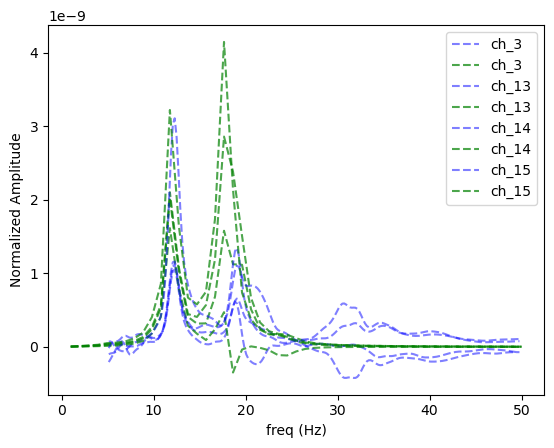

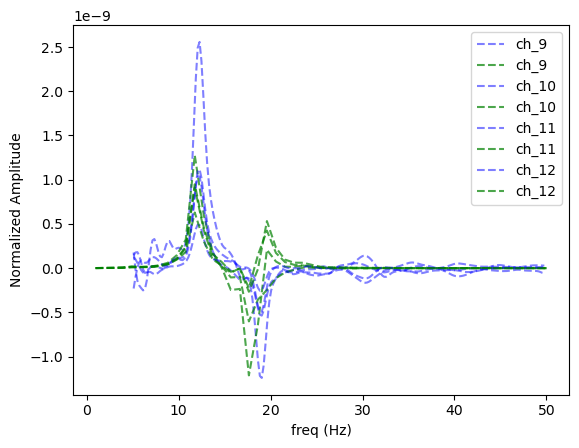

12.0386362 17.9355335 0.7424062261713724 0.6665910643617495


In [61]:
i_file = 1
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex220
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs_e = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

Exictation 22, compare to exp 13

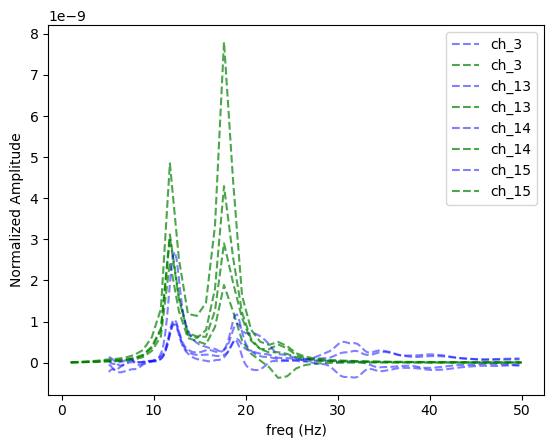

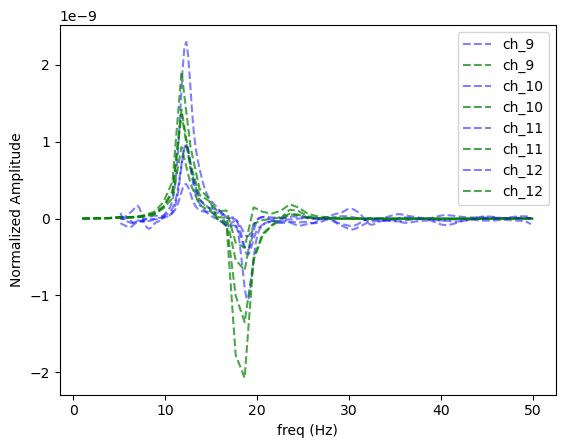

12.0386362 17.9355335 0.5528280669318424 0.5348540902399219


In [62]:
i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex22
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )